In [2]:
from matplotlib import pyplot as plt
import pandas as pd
from datetime import datetime as dt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

In [3]:
dfs = []
for year in [2019, 2020, 2021, 2022]:
    for semester in [1, 2]:
        file_path = f'Data/ca-{year}-0{semester}.csv'
        temp_df = pd.read_csv(file_path, delimiter=';', decimal=',', encoding='utf8')
        dfs.append(temp_df)
df = pd.concat(dfs, ignore_index=True)

In [4]:
#TRATAMENTO DOS DADOS GASOLINA
df['Data da Coleta'] = pd.to_datetime(df['Data da Coleta'], format='%d/%m/%Y') #muda o formato de data que ta no arquivo
df['Ano'] = df['Data da Coleta'].dt.year
df['Mês'] = df['Data da Coleta'].dt.month

# Agrupando por Município, Produto, Ano e Mês e calculando a média de Valor de Venda
df_media = df.groupby(['Municipio', 'Produto', 'Ano', 'Mês'])['Valor de Venda'].mean().reset_index()
media_mensal = df_media.groupby(['Ano', 'Mês', 'Produto'])['Valor de Venda'].mean().reset_index()

# Mesma data para todo mes
media_mensal['Data'] = pd.to_datetime(media_mensal[['Ano', 'Mês']].assign(DAY=1).astype(str).agg('-'.join, axis=1), format='%Y-%m-%d')

# Ordenando o DataFrame por data
media_mensal = media_mensal.sort_values('Data')
# Agrupando por Ano, Mês, Produto e calculando a média dos valores de venda
media_mensal = df_media.groupby(['Ano', 'Mês', 'Produto'])['Valor de Venda'].mean().reset_index()

# Filtrando apenas as linhas correspondentes a GASOLINA e ETANOL
media_mensal = media_mensal[media_mensal['Produto'].isin(['GASOLINA', 'ETANOL'])]

# Criando uma coluna de data (mesma data para todo mês, usando o último dia do mês)
media_mensal['Data'] = pd.to_datetime(media_mensal[['Ano', 'Mês']].assign(DAY=1).astype(str).agg('-'.join, axis=1), format='%Y-%m-%d')

# Ordenando o DataFrame por data
media_mensal = media_mensal.sort_values('Data')

# Produtos como colunas
df_combustiveis = media_mensal.pivot_table(index='Data', columns='Produto', values='Valor de Venda', aggfunc='mean').reset_index()

df_combustiveis = pd.concat([df_combustiveis, pd.DataFrame({'Data': ['2020-09-01'], 'GASOLINA': [None], 'ETANOL': [None]})], ignore_index=True)

# Ordene o DataFrame pela coluna 'Data'
df_combustiveis['Data'] = pd.to_datetime(df_combustiveis['Data'])
df_combustiveis = df_combustiveis.sort_values(by='Data')

# Obtenha o índice da nova data adicionada
indice_nova_data = df_combustiveis[df_combustiveis['Data'] == '2020-09-01'].index[0]

# Calcule a média entre os valores nos índices 19 e 20 para preencher a data adicionada na posição 20
media_gasolina = (df_combustiveis.loc[19, 'GASOLINA'] + df_combustiveis.loc[20, 'GASOLINA'])/2
media_etanol = (df_combustiveis.loc[19, 'ETANOL'] + df_combustiveis.loc[20, 'ETANOL'])/2
df_combustiveis.at[indice_nova_data, 'GASOLINA'] = media_gasolina
df_combustiveis.at[indice_nova_data, 'ETANOL'] = media_etanol
df_combustiveis.set_index('Data', inplace=True)



In [5]:
nome_arquivo = 'IGP-M_percentuais.csv'
# Especificar o formato da data para o parser e o encoding correto
df_igpm = pd.read_csv(nome_arquivo, delimiter=';', encoding='ISO-8859-1')
# Substituir ' Data' pelo nome correto da coluna de data

df_igpm['Data'] = pd.to_datetime(df_igpm['Data'], format='%d/%m/%Y')

# Filtrar as datas de 2019 até 2022
df_igpm = df_igpm[(df_igpm['Data'] >= '2019-01-01') & (df_igpm['Data'] <= '2022-12-31')]

# Configurar o índice como a coluna de data correta
df_igpm.set_index('Data', inplace=True)

df_igpm = df_igpm * 100  # porcentagem

igpm_mes = df_igpm['IGP-M% mês'] 
igpm_12 = df_igpm['IGP-M% 12 m'] 

In [26]:
igpm_mes = df_igpm['IGP-M% mês'] 
igpm_12 = df_igpm['IGP-M% 12 m'] 
gasolina = df_combustiveis['GASOLINA']
etanol = df_combustiveis['ETANOL']

gasolina_mes = gasolina.pct_change()*100
etanol_mes = etanol.pct_change()*100
gasolina_mes.fillna(0, inplace=True)
etanol_mes.fillna(0, inplace=True)

print(len(igpm_mes),
len(igpm_12),
len(gasolina),
len(etanol))

48 48 48 48


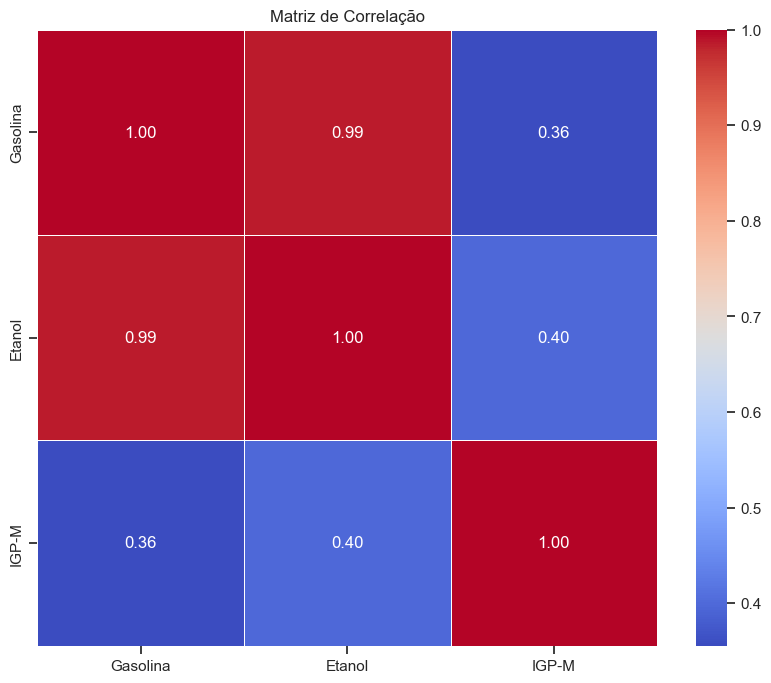

C:\Users\cyro.pereira\AppData\Local\Temp\ipykernel_12816\1806258013.py:29: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  ccf_result = ccf(df['Etanol'], df['IGP-M'], unbiased=True)


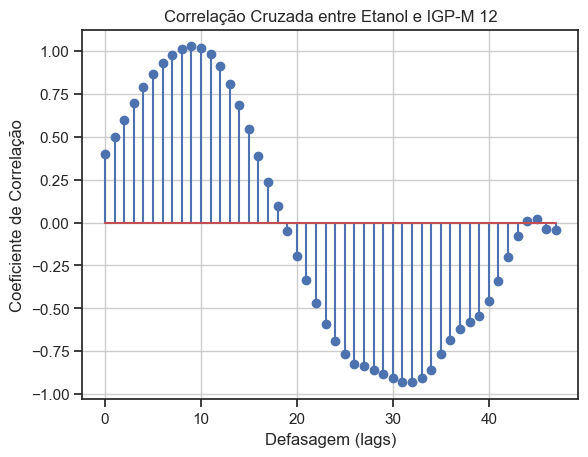

C:\Users\cyro.pereira\AppData\Local\Temp\ipykernel_12816\1806258013.py:40: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  ccf_result = ccf( df['IGP-M'],df['Etanol'], unbiased=True)


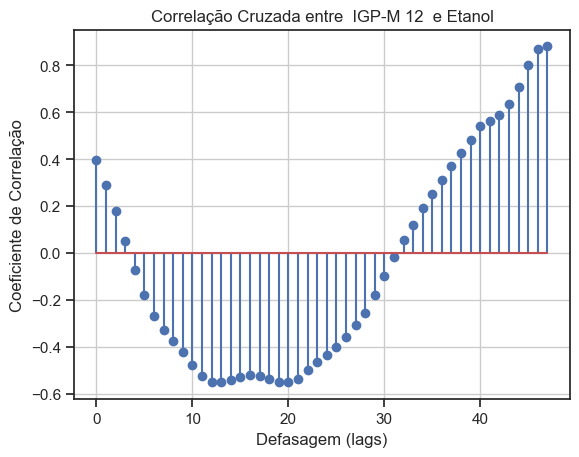

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.tsa.stattools import ccf

# Supondo que df_combustiveis e df_igpm são seus DataFrames

# Calculando as mudanças percentuais para as séries temporais


# Preenchendo valores nulos com 0
gasolina_mes.fillna(0, inplace=True)
etanol_mes.fillna(0, inplace=True)

# Criando um DataFrame com as séries temporais relevantes
df = pd.DataFrame({'Gasolina': gasolina, 'Etanol': etanol, 'IGP-M': igpm_12})

# Calculando a matriz de correlação
correlation_matrix = df.corr()

# Plotando a matriz de correlação como um mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()

# Calculando a correlação cruzada entre Etanol e IGP-M Mês
ccf_result = ccf(df['Etanol'], df['IGP-M'], unbiased=True)

# Plotando o gráfico CCF
plt.stem(ccf_result)
plt.title('Correlação Cruzada entre Etanol e IGP-M 12')
plt.xlabel('Defasagem (lags)')
plt.ylabel('Coeficiente de Correlação')
plt.grid(True)
plt.show()

# Calculando a correlação cruzada entre Etanol e IGP-M Mês
ccf_result = ccf( df['IGP-M'],df['Etanol'], unbiased=True)

# Plotando o gráfico CCF
plt.stem(ccf_result)
plt.title('Correlação Cruzada entre  IGP-M 12  e Etanol')
plt.xlabel('Defasagem (lags)')
plt.ylabel('Coeficiente de Correlação')
plt.grid(True)
plt.show()


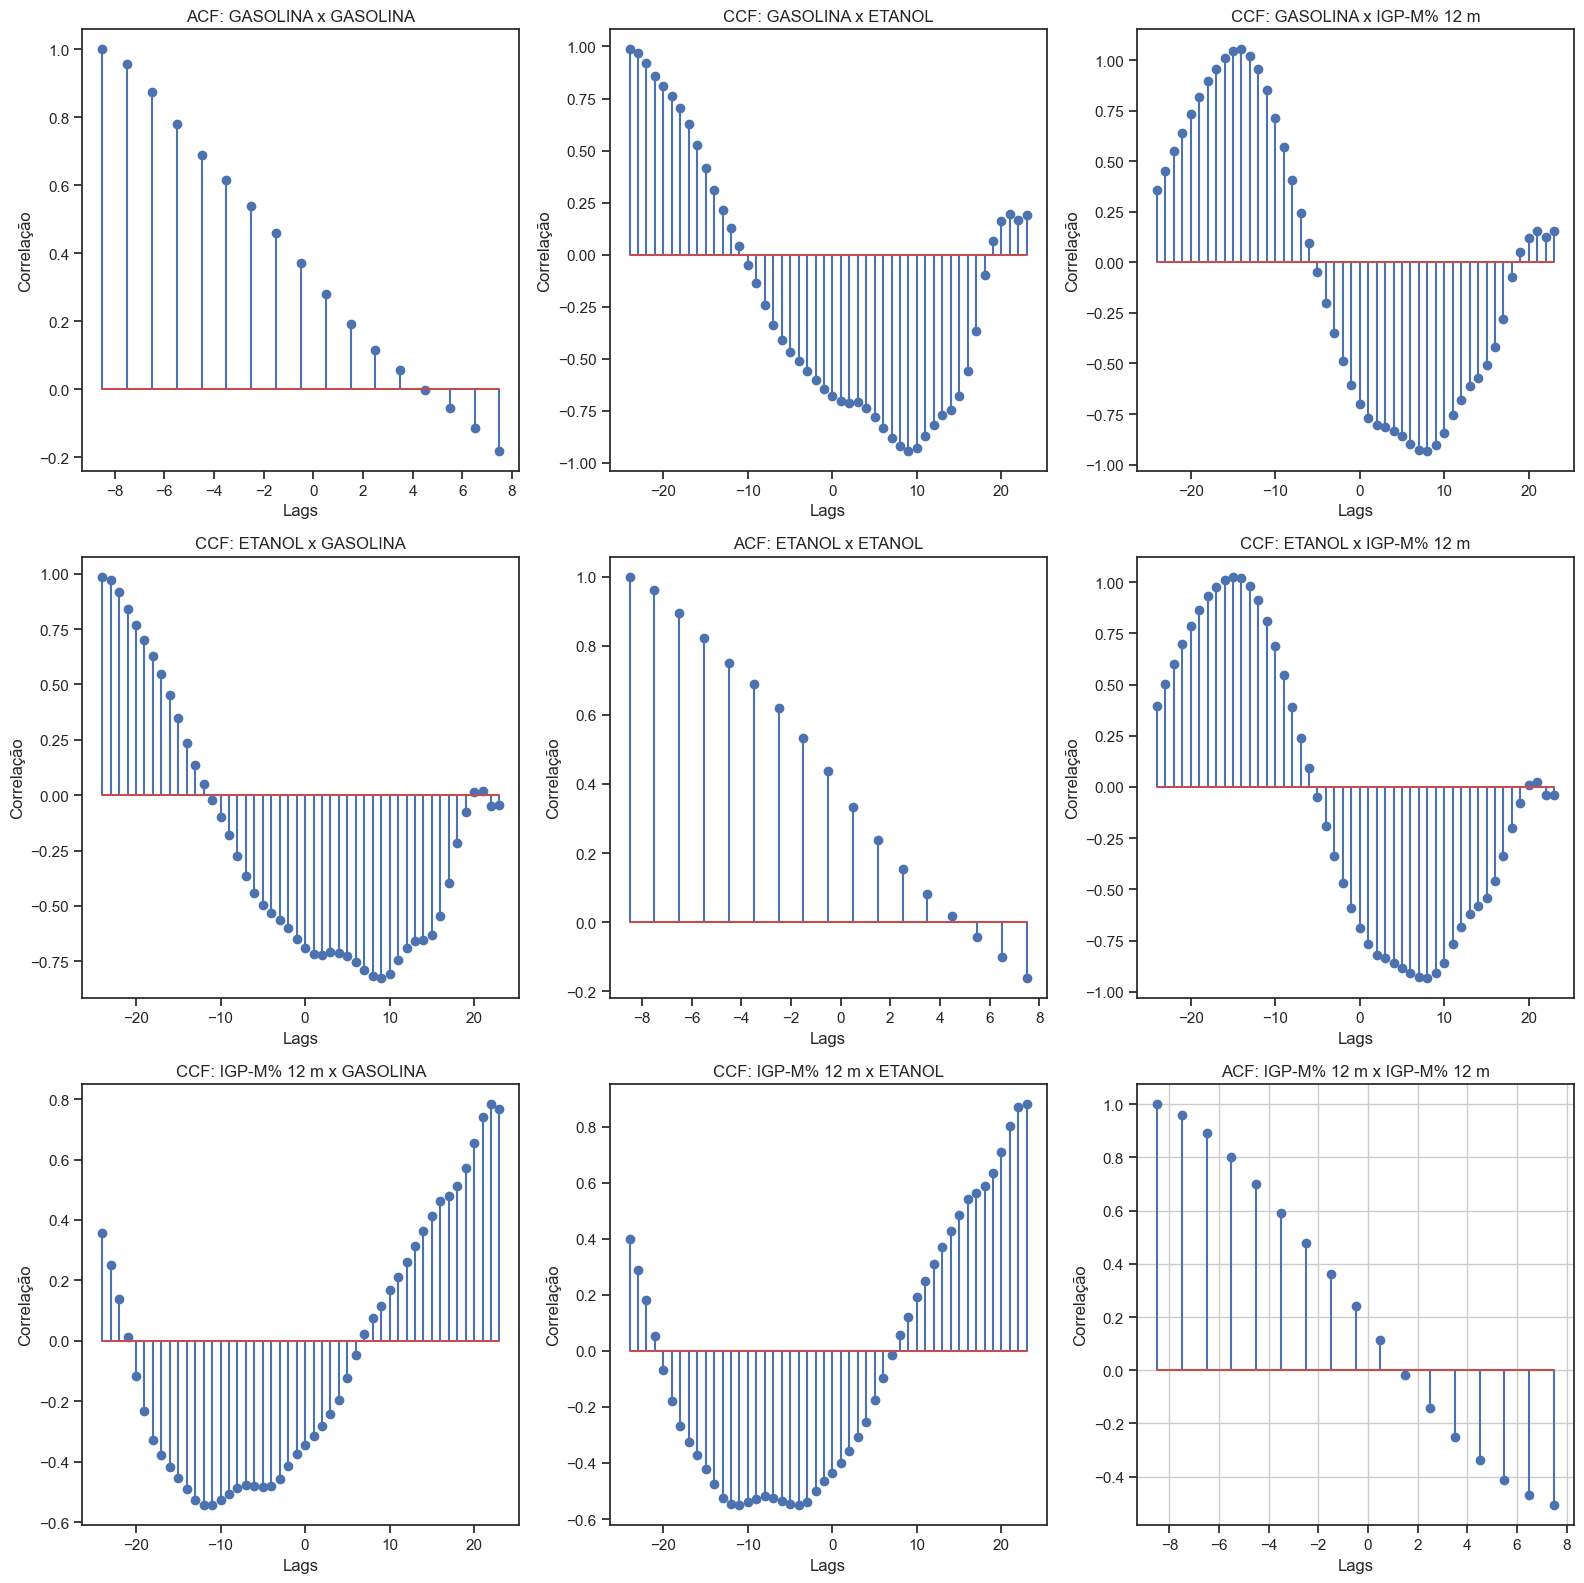

In [36]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import itertools
from statsmodels.tsa.api import VAR
series_temporais = [gasolina, etanol, igpm_12] #, gasolina_mes, etanol, etanol_mes, igpm_12, igpm_mes

# Todas as permutações possíveis de pares de séries temporais (incluindo autocorrelações)
permutacoes = list(itertools.product(series_temporais, repeat=2))

# Configurar o layout dos subplots
num_linhas, num_colunas =3, 3
fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(16, 16))

# Iterar sobre todas as permutações
for i, permutacao in enumerate(permutacoes):
    serie1, serie2 = permutacao
    
    if serie1 is not serie2:
        ccf_result = sm.tsa.stattools.ccf(serie1, serie2, adjusted=True, fft=True)
        title = f'CCF: {serie1.name} x {serie2.name}'
    else:
        ccf_result = sm.tsa.stattools.acf(serie1, fft=True)
        title = f'ACF: {serie1.name} x {serie1.name}'

    # Número de lags
    nlags = len(ccf_result)
    #print(nlags)

    # Configurar as coordenadas do subplot
    row = i // num_colunas
    col = i % num_colunas
    
    # Gerar o gráfico no subplot correspondente
    axs[row, col].stem(np.arange(-nlags/2, nlags/2), ccf_result)
    axs[row, col].set_title(title)
    axs[row, col].set_xlabel('Lags')
    axs[row, col].set_ylabel('Correlação')
    plt.grid()
# Ajustar o layout
plt.tight_layout()

plt.show()